<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [2]:
!pip install datasets

Импорт необходимых библиотек

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
from torch.autograd import Variable 


import seaborn
seaborn.set(palette='summer')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [6]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [7]:
sentences = []
word_threshold = 32

for comment in tqdm(dataset['train']['text']):
    sentences.extend([[sentence] for sentence in sent_tokenize(comment) if len(sent_tokenize(sentence)) < word_threshold])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 270853


Посчитаем для каждого слова его встречаемость.

In [9]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(sentences):
    for word in word_tokenize(sentence[0]):
        words[word] += 1

  0%|          | 0/270853 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
vocab = set()
vocab_size = 40000

vocab = set(list({k : v for k, v in sorted(words.items(), key=lambda item:item[1], reverse=True)})[:vocab_size])
for w in ['<unk>', '<bos>', '<eos>', '<pad>']:
    vocab.add(w) 
# Наполнение словаря

In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [12]:
vocab_size = len(vocab)

In [13]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [14]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [15]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx][0])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [16]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

In [17]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 16

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size, drop_last=True)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size, drop_last=True)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size,  drop_last=True)

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [17]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [18]:
def train_model(model, criterion, optimizer, n_epochs):
    
    losses = []
    perplexities = {'eval':[], 'train':[]}
    
    for epoch in range(n_epochs):
        model.train()
        epoch_losses = []        

        for batch in tqdm(train_dataloader,  desc=f'Training epoch {epoch}:'):
            model.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        
            with torch.no_grad():
                torch.cuda.empty_cache()

        losses.append(np.sum(epoch_losses) / len(epoch_losses))
        
        perplexities['eval'].append(evaluate(model, criterion, eval_dataloader))
        #perplexities['train'].append(evaluate(model, criterion, train_dataloader))
        
    return (losses, perplexities)

### Первый эксперимент (2 балла)

Реализуем model RNN на основе GRU:

In [19]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [20]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [21]:
hidden_dim = 256
num_layers = 2
n_epochs = 7

model = CharLM(hidden_dim, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())    

losses, perplexities = train_model(model, criterion, optimizer, n_epochs)

Training epoch 0::   0%|          | 0/13542 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/13542 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/13542 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/13542 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/13542 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/13542 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/13542 [00:00<?, ?it/s]

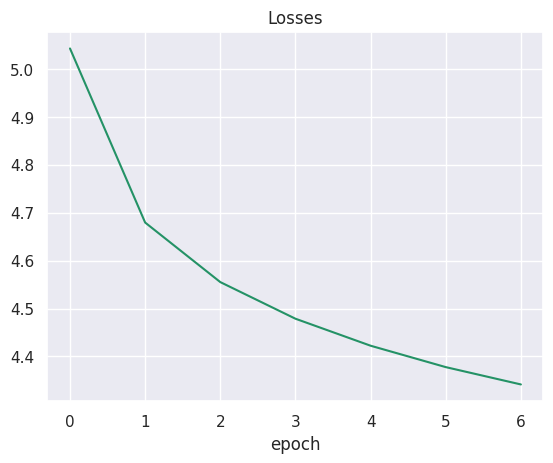

In [22]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

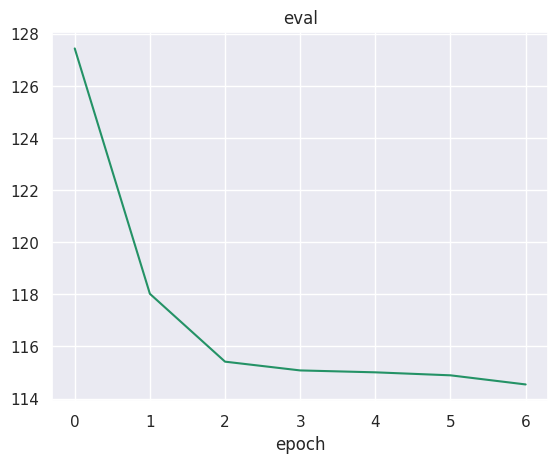

In [23]:
for data in ['eval']:
    plt.plot(np.arange(len(perplexities[data])), perplexities[data])
    plt.title(data)
    plt.xlabel("epoch")
    plt.show()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [18]:
def evaluate_LSTM(model, criterion, state_h, state_c) -> float:
    model.eval()
    perplexity = []
    
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'], (state_h, state_c))[0].flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [19]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers):
        super().__init__()
        
        self.num_layers = num_layers #number of layers
        self.vocab_size = vocab_size #input size
        self.hidden_dim = hidden_dim #hidden state
        
        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)


    def forward(self, input_batch, prev_state) -> torch.Tensor:
        embeddings = self.embeddings(input_batch)
        output, state = self.lstm(embeddings, prev_state)
        output = self.dropout(self.linear(output))
        projection = self.projection(self.non_lin(output))
        
        return projection, state
    
    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, sequence_length, self.hidden_dim).to(device))

In [20]:
def train_LSTM(model, criterion, optimizer, n_epochs, batch_size):
    
    losses = []
    perplexities = {'eval':[], 'train':[]}
    
    for epoch in range(n_epochs):
        model.train()
        epoch_losses = []
        sequence_len = batch_size
        '''
        for example_batch in train_dataloader:
            sequence_len = len(example_batch['input_ids'][0])
            break
        ''' 
        
        state_h, state_c = model.init_state(sequence_len)
        for batch in tqdm(train_dataloader,  desc=f'Training epoch {epoch}:'):
            model.zero_grad()
            logits, (state_h, state_c) = model(batch['input_ids'], (state_h, state_c))
            logits = logits.flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
               
            state_h = state_h.detach()
            state_c = state_c.detach()
            
            with torch.no_grad():
                torch.cuda.empty_cache()
        
        losses.append(np.sum(epoch_losses) / len(epoch_losses))
        
        perplexities['eval'].append(evaluate_LSTM(model, criterion, state_h, state_c))
        #perplexities['train'].append(evaluate(model, criterion, train_dataloader))
        
    return (losses, perplexities)

In [21]:
hidden_dim = 256
num_layers = 2
n_epochs = 7

model = LanguageModel(hidden_dim, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

d = next(iter(train_dataloader))['input_ids']
h = torch.rand(d.shape)
c = torch.rand(d.shape)

h.shape, d.shape
batch_size, vocab_size
losses, perplexities = train_LSTM(model, criterion, optimizer, n_epochs, batch_size)

Training epoch 0::   0%|          | 0/13542 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/13542 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/13542 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/13542 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/13542 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/13542 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/13542 [00:00<?, ?it/s]

In [ ]:
# Проведите второй эксперимент

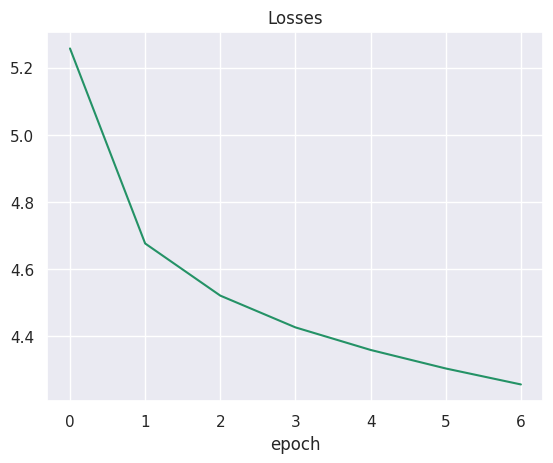

In [22]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

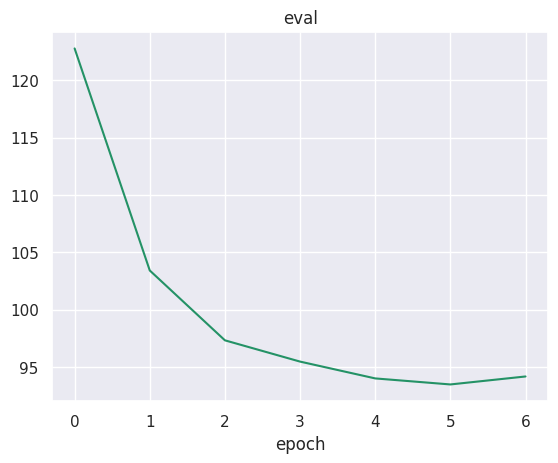

In [23]:
for data in ['eval']:
    plt.plot(np.arange(len(perplexities[data])), perplexities[data])
    plt.title(data)
    plt.xlabel("epoch")
    plt.show()

In [25]:
min(perplexities['eval'])

93.47434203506361

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

У LSTM показатели лучше: 93 против 114 на Перплексии. Можно попробовать увеличить кол-во слоев и p(drop out)